In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Reason to Choose YOLO:

Designed for real-time detection due to its high speed and efficiency.

Single neural network architecture processes the entire image in one pass, making it faster than region-based approaches.

YOLOv5 or YOLOv8 are commonly used variants with excellent performance on videos.

Pretrained models are widely available and can be fine-tuned on your dataset.

Drawbacks:

May sacrifice some accuracy, particularly for small objects or cluttered environments.

Use Case in Sports Videos:

Works well for detecting players and balls in high-motion sports scenarios.

Faster R-CNN (Region-Based Convolutional Neural Network):

Reason to Choose Faster R-CNN:

Known for high accuracy due to its two-stage detection process:

Region Proposal Network (RPN) identifies potential object locations.

A second stage refines the bounding boxes and classifies objects.

Robust to occlusion and complex backgrounds.

Drawbacks:

**Slower than YOLO, making it less suitable for real-time applications.**

Use Case in Sports Videos:

Ideal for post-match analysis or scenarios where real-time performance is not critical.


In [5]:
# Environment Setup

!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

import sys
sys.path.append('/kaggle/working/yolov5')

Cloning into 'yolov5'...
remote: Enumerating objects: 17265, done.
remote: Total 17265 (delta 0), reused 0 (delta 0), pack-reused 17265 (from 1)
Receiving objects: 100% (17265/17265), 16.11 MiB | 32.67 MiB/s, done.
Resolving deltas: 100% (11858/11858), done.
/kaggle/working/yolov5/yolov5


In [2]:
# Read the "football.txt" file

import os
import csv
import glob
import shutil

football_txt_path = "/kaggle/input/sportsmot/sportsmot_publish/splits_txt/football.txt"

# Read the file and build a set of video names
football_videos = set()
with open(football_txt_path, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            football_videos.add(line)  

print("Number of football videos listed:", len(football_videos))


Number of football videos listed: 80


In [3]:
# Create function to convert MOT → YOLO

def convert_mot_to_yolo(mot_file, output_labels_dir, image_width=1280, image_height=720, default_class_id=0):
    """
    Convert MOT Challenge style annotations (gt.txt) to YOLO format.
    MOT gt.txt columns typically: frame, ID, x, y, w, h, conf, class, visibility
    We'll assume a single class (default_class_id=0).
    """
    with open(mot_file, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            # Skip empty lines or commented lines
            if not row or row[0].startswith('#'):
                continue
            
            # Parse columns
            frame_id = int(row[0])      # frame index
            x = float(row[2])          # bounding box left
            y = float(row[3])          # bounding box top
            w = float(row[4])          # bounding box width
            h = float(row[5])          # bounding box height
            
            # Convert to YOLO normalized format
            x_center = x + w / 2.0
            y_center = y + h / 2.0
            x_center_norm = x_center / image_width
            y_center_norm = y_center / image_height
            w_norm = w / image_width
            h_norm = h / image_height
            
            # For single class, we can just use 0
            class_id = default_class_id
            
            # YOLO line
            yolo_line = f"{class_id} {x_center_norm:.6f} {y_center_norm:.6f} {w_norm:.6f} {h_norm:.6f}\n"
            
            # frame 1 => "000001.txt"
            frame_str = f"{frame_id:06d}"
            label_file = os.path.join(output_labels_dir, f"{frame_str}.txt")
            
            # Append or create
            with open(label_file, 'a') as lf:
                lf.write(yolo_line)


In [4]:
# Create YOLO-Folder Structure for Football-Only

yolo_football_base = "/kaggle/working/sportsmot_yolo_football"  # new output folder
os.makedirs(yolo_football_base, exist_ok=True)

splits = ["train", "val", "test"]
for s in splits:
    os.makedirs(os.path.join(yolo_football_base, s, "images"), exist_ok=True)
    os.makedirs(os.path.join(yolo_football_base, s, "labels"), exist_ok=True)

# Original MOT dataset root
sportsmot_root = "/kaggle/input/sportsmot/sportsmot_publish/dataset"


In [5]:
# Copy ONLY football videos from each split

for s in splits:
    original_split_dir = os.path.join(sportsmot_root, s)
    new_images_dir = os.path.join(yolo_football_base, s, "images")
    
    # List each VIDEO_NAME in that split
    for video_name in os.listdir(original_split_dir):
        # Check if this video is in "football_videos" set
        if video_name not in football_videos:
            continue  # skip non-football videos
        
        video_path = os.path.join(original_split_dir, video_name)
        img1_path = os.path.join(video_path, "img1")
        
        if not os.path.isdir(img1_path):
            continue
        
        # Create subfolder for that video in images/
        new_images_video_dir = os.path.join(new_images_dir, video_name)
        os.makedirs(new_images_video_dir, exist_ok=True)
        
        # Copy all .jpg frames
        for jpg_file in glob.glob(os.path.join(img1_path, "*.jpg")):
            shutil.copy(jpg_file, new_images_video_dir)

In [6]:
# Convert MOT → YOLO for football videos

for s in splits:
    original_split_dir = os.path.join(sportsmot_root, s)
    new_labels_dir = os.path.join(yolo_football_base, s, "labels")
    
    for video_name in os.listdir(original_split_dir):
        # Only convert if it's a known football video
        if video_name not in football_videos:
            continue
        
        gt_file = os.path.join(original_split_dir, video_name, "gt", "gt.txt")
        if not os.path.isfile(gt_file):
            continue
        
        # Create subfolder for that video in labels/
        new_labels_video_dir = os.path.join(new_labels_dir, video_name)
        os.makedirs(new_labels_video_dir, exist_ok=True)
        
        # Convert
        convert_mot_to_yolo(
            mot_file=gt_file,
            output_labels_dir=new_labels_video_dir,
            image_width=1280,   
            image_height=720,
            default_class_id=0
        )

print("Football-only subset is now in YOLO format at:", yolo_football_base)


Football-only subset is now in YOLO format at: /kaggle/working/sportsmot_yolo_football


In [7]:
# Create YOLO Data Config File

# For example, "sportsmot_football.yaml"
yaml_path = "/kaggle/working/sportsmot_football.yaml"
yaml_content = f"""
train: {yolo_football_base}/train/images
val: {yolo_football_base}/val/images
test: {yolo_football_base}/test/images

names:
  0: player
  1: ball
""" 

with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("Created YOLO data config for football subset at:", yaml_path)


Created YOLO data config for football subset at: /kaggle/working/sportsmot_football.yaml


In [ ]:
#  Train YOLOv5 on Football-Only

!python train.py \
   --img 1280 \
   --batch 4 \
   --epochs 5 \
   --data {yaml_path} \
   --weights yolov5s.pt \
   --name sportsmot_football_yolov5 \
   --project runs/train \



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-01-27 17:31:12.721407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-27 17:31:12.910238: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-27 17:31:12.970446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to regi

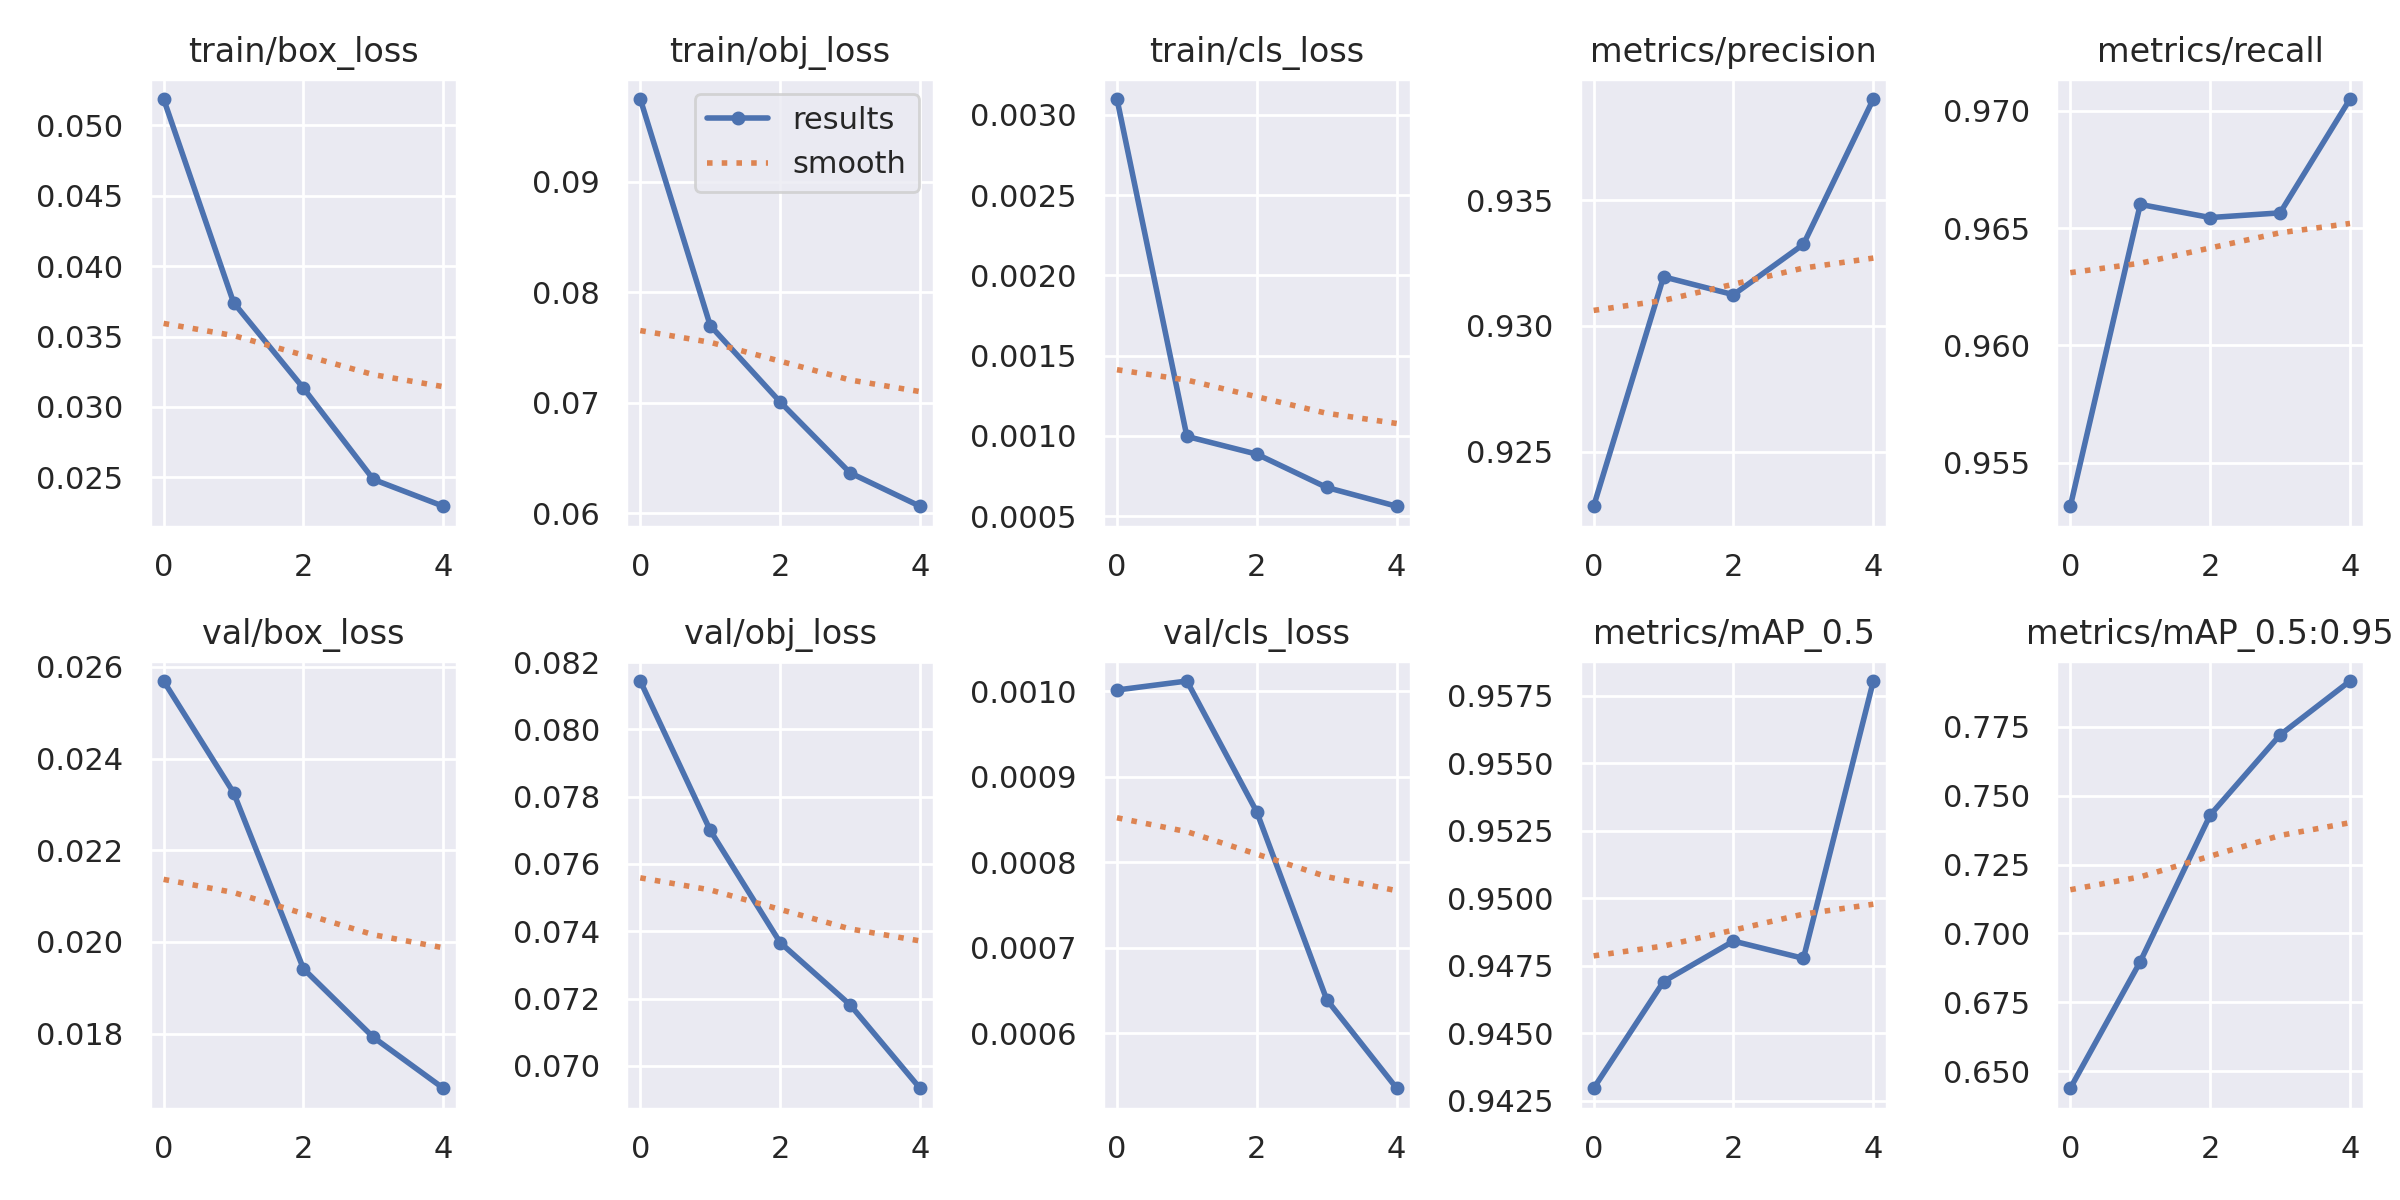

detect: weights=['/kaggle/working/yolov5/yolov5/runs/train/sportsmot_football_yolov5/weights/best.pt'], source=/kaggle/working/sportsmot_yolo_football/test/images/v_-hhDbvY5aAM_c001/000001.jpg, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/yolov5/yolov5/runs/detect, name=sportsmot_images, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-397-gde62f93c Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/working/sportsmot_yolo_football/test/images/v_-hhDbvY5aAM_c001/000001.jpg: 736x1280 8 players, 30.6ms
Speed: 0.9ms pre-process

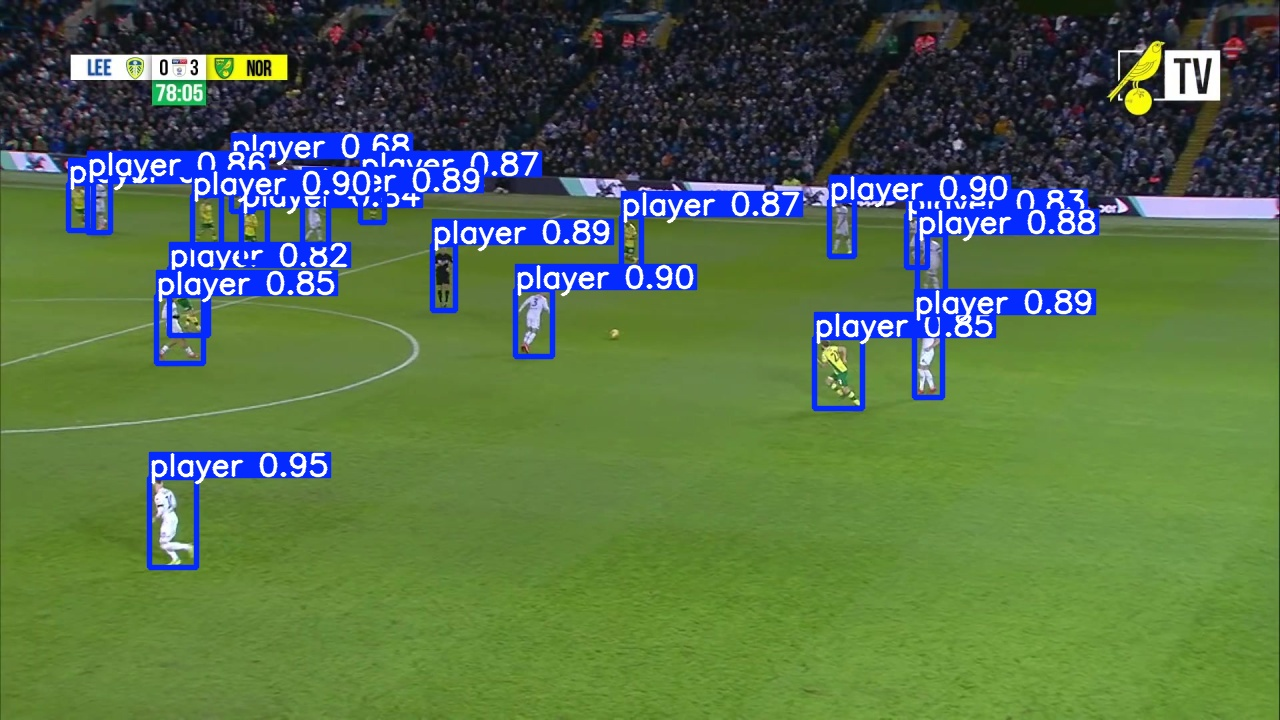

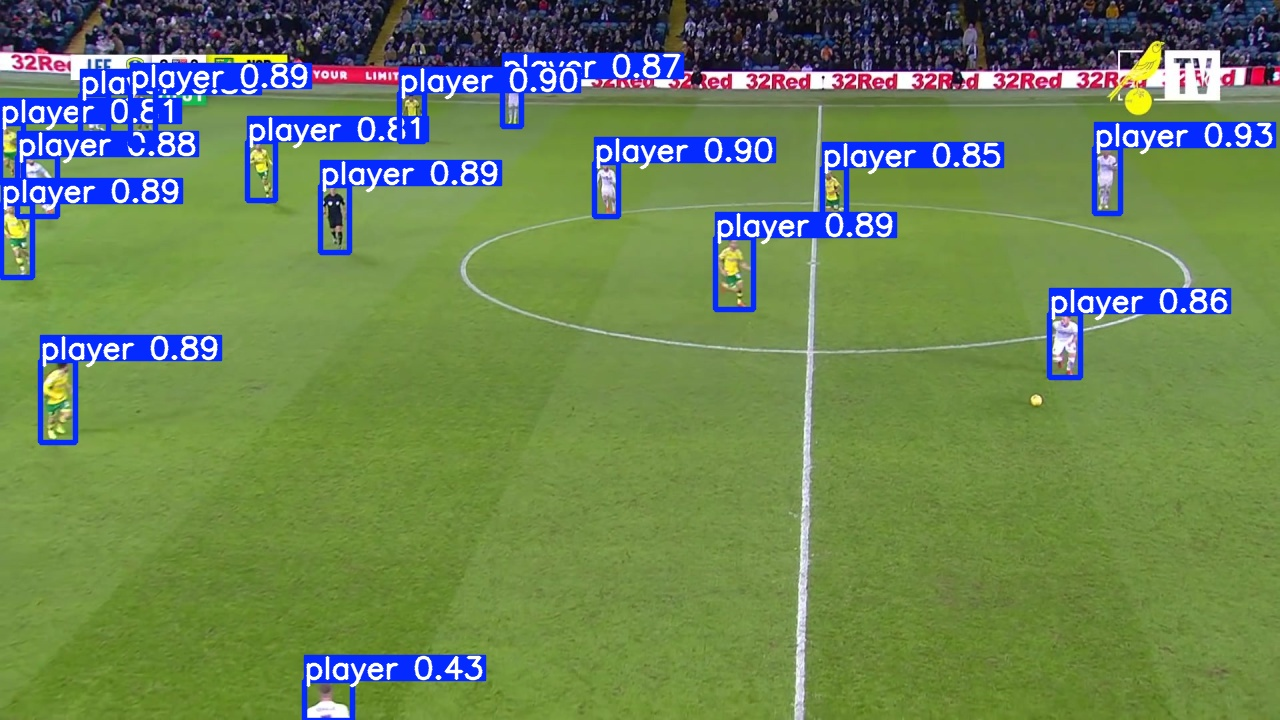

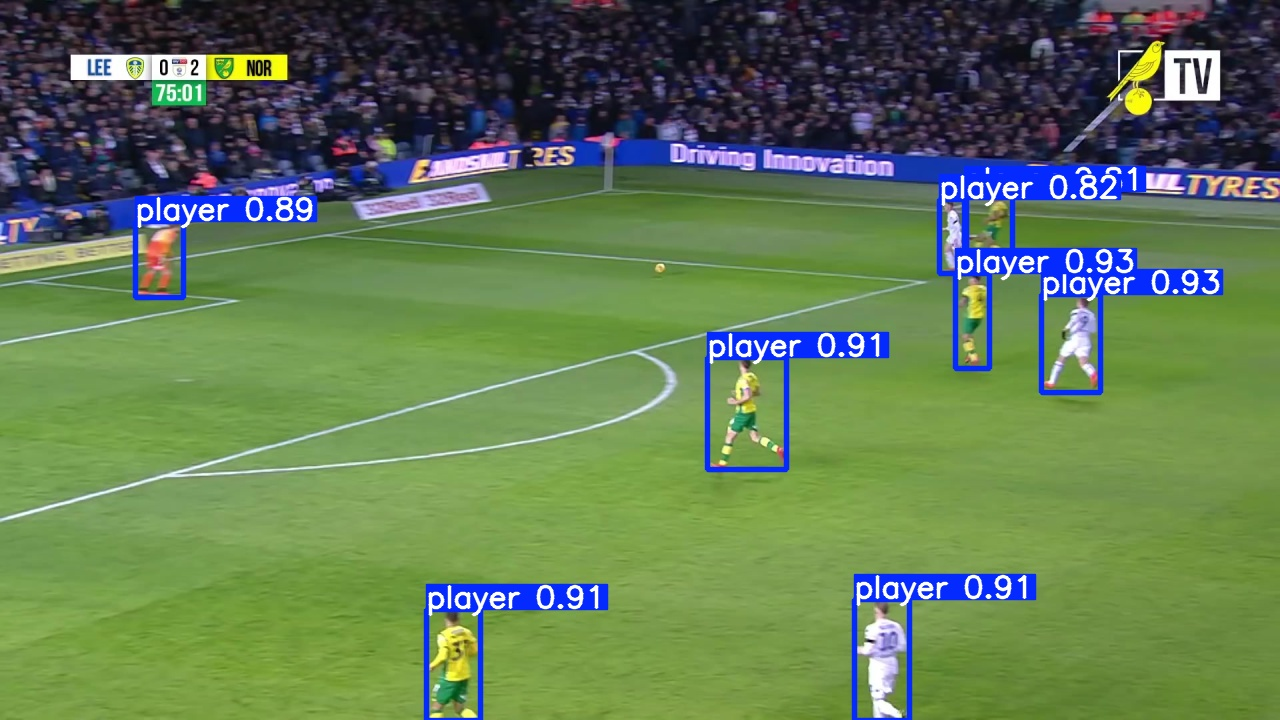

In [ ]:
# Display training results

from IPython.display import Image, display

results_img = "/kaggle/working/yolov5/yolov5/runs/train/sportsmot_football_yolov5/results.png"
display(Image(filename=results_img))


sample_images = [
    "/kaggle/working/sportsmot_yolo_football/test/images/v_-hhDbvY5aAM_c001/000001.jpg",
    "/kaggle/working/sportsmot_yolo_football/test/images/v_-hhDbvY5aAM_c002/000002.jpg",
    "/kaggle/working/sportsmot_yolo_football/test/images/v_-hhDbvY5aAM_c005/000003.jpg",
    "/kaggle/working/sportsmot_yolo_football/test/images/v_-hhDbvY5aAM_c006/000004.jpg",
    "/kaggle/working/sportsmot_yolo_football/test/images/v_-hhDbvY5aAM_c007/000005.jpg",
    "/kaggle/working/sportsmot_yolo_football/test/images/v_-hhDbvY5aAM_c008/000006.jpg"
]

for img_path in sample_images:
    !python detect.py \
      --weights /kaggle/working/yolov5/yolov5/runs/train/sportsmot_football_yolov5/weights/best.pt \
      --source {img_path} \
      --img 1280 \
      --conf 0.25 \
      --project /kaggle/working/yolov5/yolov5/runs/detect \
      --name sportsmot_images \
      --exist-ok


det_results_dir = "/kaggle/working/yolov5/yolov5/runs/detect/sportsmot_images"
for f in os.listdir(det_results_dir):
    if f.endswith('.jpg'):
        display(Image(filename=os.path.join(det_results_dir, f)))

In [ ]:
# Run validation
!python val.py \
  --weights /kaggle/working/yolov5/yolov5/runs/train/sportsmot_football_yolov5/weights/best.pt \
  --data /kaggle/working/sportsmot_football.yaml \
  --task val \
  --img 1280


val: data=/kaggle/working/sportsmot_football.yaml, weights=['/kaggle/working/yolov5/yolov5/runs/train/sportsmot_football_yolov5/weights/best.pt'], batch_size=32, imgsz=1280, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-397-gde62f93c Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /kaggle/working/sportsmot_yolo_football/val/labels/v_2QhNRucNC7E_c
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yo

                 Class     Images  Instances          P          R      mAP50   
                   all       9058     117024      0.939       0.97      0.958      
                player       9058     117024      0.939       0.97      0.958 

**-------------------------------------------------------------------------------------**

**2.2 SOT**

Explanation of Algorithm Choice

CSRT Tracker (Discriminative Correlation Filter with Channel and Spatial Reliability):

CSRT is robust to scale variations and performs well when the object undergoes slight deformations or occlusion.

It is computationally efficient and easy to implement.

It is readily available in OpenCV and supports tracking in videos with reasonable frame rates.


In [2]:
import cv2
import os
from glob import glob

# Path to the directory containing image frames
image_folder = "/kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c001/img1"
output_video_path = "/kaggle/working/sample_video.mp4"

# Get all image files in the directory
images = sorted(glob(os.path.join(image_folder, "*.jpg")))

# Define video properties
frame_width, frame_height = 1280, 720
fps = 25

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Loop through images and write them to the video
for img_path in images:
    frame = cv2.imread(img_path)
    if frame is None:
        continue
    frame_resized = cv2.resize(frame, (frame_width, frame_height))
    out.write(frame_resized)

# Release the video writer
out.release()
print(f"Sample video created at: {output_video_path}")


Sample video created at: /kaggle/working/sample_video.mp4


In [1]:
# 1. Clone YOLOv5 Repository and Install Dependencies
!git clone https://github.com/ultralytics/yolov5.git /kaggle/working/yolov5
%cd /kaggle/working/yolov5
!pip install -r requirements.txt

# 2. Import Libraries
import os
import cv2
import numpy as np

# 3. Paths
yolo_repo_path = "/kaggle/working/yolov5"
weights_path = "/kaggle/input/bestweights/best.pt"  
first_frame_path = "/kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c001/img1/000001.jpg"  # Replace with the path to the first frame
output_dir = "/kaggle/working/yolo_output"

# 4. Ensure Output Directory Exists
os.makedirs(output_dir, exist_ok=True)

# 5. Run YOLO Detection on the First Frame
!python /kaggle/working/yolov5/detect.py \
    --weights {weights_path} \
    --source {first_frame_path} \
    --img-size 1280 \
    --conf-thres 0.25 \
    --save-txt \
    --project {output_dir} \
    --name detect_first_frame \
    --exist-ok

# 6. Read YOLO Detection Results
output_txt = os.path.join(output_dir, "detect_first_frame", "labels", "000001.txt")
if not os.path.isfile(output_txt):
    print("No detection results found for the first frame.")
    exit()


fatal: destination path '/kaggle/working/yolov5' already exists and is not an empty directory.
/kaggle/working/yolov5
detect: weights=['/kaggle/input/bestweights/best.pt'], source=/kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c001/img1/000001.jpg, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=/kaggle/working/yolo_output, name=detect_first_frame, exist_ok=True, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-397-gde62f93c Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c001/img1/000001.jpg: 736x1280 8 play

In [2]:
# Parse the YOLO Output
with open(output_txt, "r") as f:
    line = f.readline().strip().split()
    class_id = int(line[0])  # Class ID
    x_center, y_center, width, height = map(float, line[1:])
    frame_width, frame_height = 1280, 720  # Assuming the image resolution

    # Convert YOLO Format to OpenCV Format
    x = int((x_center - width / 2) * frame_width)
    y = int((y_center - height / 2) * frame_height)
    w = int(width * frame_width)
    h = int(height * frame_height)
    bbox = (x, y, w, h)

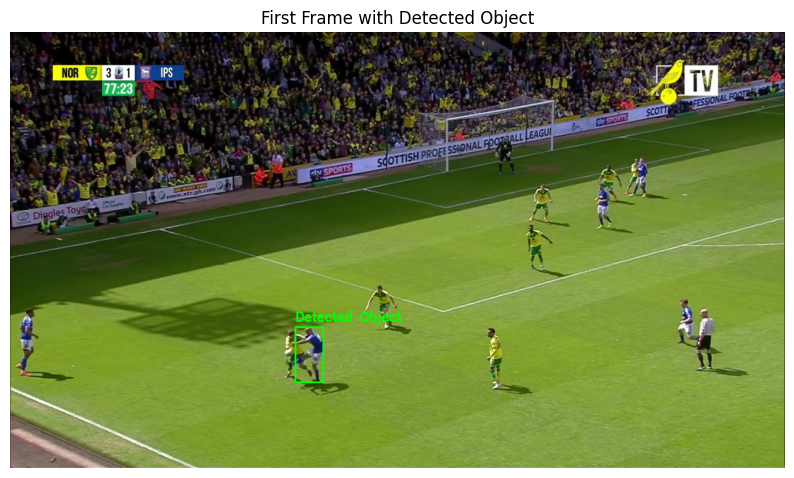

In [ ]:
import matplotlib.pyplot as plt

# 7. Display the Detected Bounding Box
frame = cv2.imread(first_frame_path)
cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
cv2.putText(frame, "Detected Object", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# Save and Display the Image
detected_image_path = "/kaggle/working/first_frame_detected.jpg"
cv2.imwrite(detected_image_path, frame)

# Display the Image Inline
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("First Frame with Detected Object")
plt.axis("off")
plt.show()


In [4]:
# Initialize CSRT Tracker with Detected Bounding Box
tracker = cv2.TrackerCSRT_create()
video_path = "/kaggle/working/sample_video.mp4"  

# Open the Video File
video = cv2.VideoCapture(video_path)
video.set(cv2.CAP_PROP_POS_FRAMES, 0)  # Set to the first frame
ret, frame = video.read()
if not ret:
    print("Error: Unable to read the video")
    video.release()
    exit()

# Initialize Tracker
tracker.init(frame, bbox)


In [5]:
# Start Tracking
tracked_positions = []  # List to store tracked positions
output_frames_dir = "/kaggle/working/tracked_frames"
os.makedirs(output_frames_dir, exist_ok=True)

frame_idx = 0
while True:
    ret, frame = video.read()
    if not ret:
        break

    # Update Tracker
    ok, bbox = tracker.update(frame)
    if ok:
        # Draw Bounding Box
        x, y, w, h = [int(v) for v in bbox]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        center_x, center_y = int(x + w / 2), int(y + h / 2)
        tracked_positions.append((center_x, center_y))
    else:
        cv2.putText(frame, "Tracking failure", (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 0, 255), 2)

    # Save the Frame
    frame_output_path = os.path.join(output_frames_dir, f"frame_{frame_idx:04d}.jpg")
    cv2.imwrite(frame_output_path, frame)
    frame_idx += 1

video.release()

# Save Tracked Positions for Analysis
np.save("/kaggle/working/tracked_positions.npy", tracked_positions)


**6. HeatMap**

**Bonus**

(-0.5, 1279.5, 719.5, -0.5)

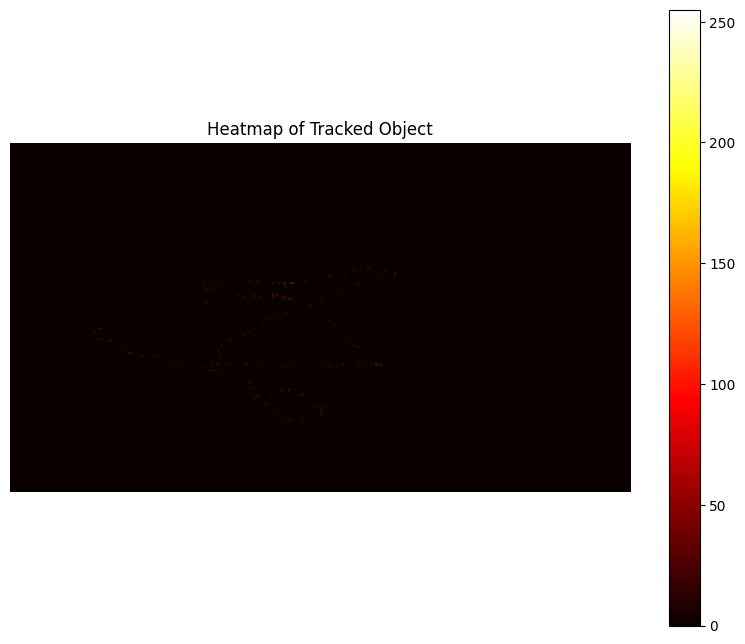

In [ ]:
# Heatmap Visualization of Tracked Positions
tracked_positions = np.load("/kaggle/working/tracked_positions.npy")
heatmap = np.zeros((720, 1280))

# Populate Heatmap
for (x, y) in tracked_positions:
    heatmap[y, x] += 1

# Normalize Heatmap
heatmap = cv2.normalize(heatmap, None, 0, 255, cv2.NORM_MINMAX)
heatmap = np.uint8(heatmap)

# Display Heatmap
plt.figure(figsize=(10, 8))
plt.title("Heatmap of Tracked Object")
plt.imshow(heatmap, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.axis("off")


In [7]:
import imageio

# Path to save the output GIF
gif_path = "/kaggle/working/tracking_output.gif"

# Get all saved frames
frame_files = sorted(
    [os.path.join(output_frames_dir, f) for f in os.listdir(output_frames_dir) if f.endswith(".jpg")]
)

# Create the GIF
with imageio.get_writer(gif_path, mode="I", duration=0.04) as writer:  # duration: 0.04s per frame (25 fps)
    for frame_file in frame_files:
        frame = imageio.imread(frame_file)
        writer.append_data(frame)

print(f"GIF saved at: {gif_path}")



<ipython-input-7-01b90cf1fa34>:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  frame = imageio.imread(frame_file)


GIF saved at: /kaggle/working/tracking_output.gif


**GIFs and videos are in SOT_Videos folder**

**3. Common Challenges in Single Object Tracking**

Single Object Tracking (SOT) faces several challenges that can significantly affect the performance of the tracking algorithm. Here are some key challenges:

1. Occlusion:
Explanation: The object of interest may get partially or completely occluded by other objects or obstacles in the scene.
Impact on Tracking: When the object is temporarily invisible, the tracker may lose track and start following an incorrect object or location.
Mitigation Strategies:
Use robust algorithms like Siamese Networks that learn strong visual features.
Combine temporal information from previous frames to infer the object's trajectory.

2. Scale Variation:
Explanation: The size of the object may change due to its distance from the camera (e.g., moving closer or farther away).
Impact on Tracking: Trackers that rely on fixed-size bounding boxes may fail to adjust to these variations, leading to inaccurate tracking.
Mitigation Strategies:
Use scale-adaptive trackers such as the CSRT tracker, which adjusts the bounding box dynamically.
Pretrain models on datasets with diverse object scales.

3. Illumination Changes:
Explanation: Sudden or gradual changes in lighting (e.g., shadows, bright sunlight, or indoor-to-outdoor transitions) can make the object harder to detect.
Impact on Tracking: The algorithm may fail to identify the object due to changes in its appearance.
Mitigation Strategies:
Use trackers with feature extraction methods that are invariant to lighting conditions.
Apply preprocessing techniques like histogram equalization to normalize lighting.

4. Motion Blur:
Explanation: Rapid movement of the object or the camera can result in blurred frames.
Impact on Tracking: Motion blur reduces the object's distinguishable features, leading to inaccurate bounding box updates.
Mitigation Strategies:
Use motion-aware models that can handle blurred frames.
Train models on augmented datasets with synthetic motion blur.


**I also made some gifs to show you these problems. I put them in the SOT_problems folder**

**4.**

In [15]:
import os
import cv2
import numpy as np

# Paths
val_images_dir = "/kaggle/working/sportsmot_yolo_football/val/images/v_2QhNRucNC7E_c017"  # Path to validation images
val_labels_dir = "/kaggle/working/sportsmot_yolo_football/val/labels/v_2QhNRucNC7E_c017"  # Path to validation labels


# Helper Function: Compute IoU
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

# Helper Function: Compute Center Distance Error (CDE)
def compute_cde(box1, box2):
    center1 = ((box1[0] + box1[2]) / 2, (box1[1] + box1[3]) / 2)
    center2 = ((box2[0] + box2[2]) / 2, (box2[1] + box2[3]) / 2)
    cde = np.sqrt((center1[0] - center2[0])**2 + (center1[1] - center2[1])**2)
    return cde

# Metrics
iou_scores = []
cde_scores = []
success_frames = 0
total_frames = 0

# Load Images and Initialize Tracker
images = sorted(os.listdir(val_images_dir))
labels = sorted(os.listdir(val_labels_dir))

# Initialize Tracker with First Image
first_image_path = os.path.join(val_images_dir, images[0])
first_label_path = os.path.join(val_labels_dir, labels[0])

first_frame = cv2.imread(first_image_path)
with open(first_label_path, "r") as f:
    target_bbox = None
    img_height, img_width = first_frame.shape[:2]
    min_distance = float('inf')
    target_x1, target_y1, target_x2, target_y2 = None, None, None, None

    # Choose the player closest to the center of the frame
    for line in f.readlines():
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)
        
        # Compute distance from the center of the frame
        player_center_x = (x1 + x2) / 2
        player_center_y = (y1 + y2) / 2
        frame_center_x = img_width / 2
        frame_center_y = img_height / 2
        distance_to_center = np.sqrt((player_center_x - frame_center_x)**2 + (player_center_y - frame_center_y)**2)
        
        # Select the player closest to the center
        if distance_to_center < min_distance:
            min_distance = distance_to_center
            target_bbox = (x1, y1, x2 - x1, y2 - y1)

if target_bbox is None:
    raise ValueError("No players found in the first frame.")

# Initialize CSRT Tracker
tracker = cv2.TrackerCSRT_create()
tracker.init(first_frame, target_bbox)

# Process Remaining Images
for i, image_file in enumerate(images[1:], 1):
    image_path = os.path.join(val_images_dir, image_file)
    label_path = os.path.join(val_labels_dir, labels[i])

    frame = cv2.imread(image_path)

    # Update Tracker
    success, tracked_bbox = tracker.update(frame)
    if not success:
        continue

    x1, y1, w, h = [int(v) for v in tracked_bbox]
    x2, y2 = x1 + w, y1 + h
    tracked_box = [x1, y1, x2, y2]

    # Load Ground Truth for Current Frame
    with open(label_path, "r") as f:
        ground_truth_box = None
        min_distance = float('inf')
        for line in f.readlines():
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            gt_x1 = int((x_center - width / 2) * img_width)
            gt_y1 = int((y_center - height / 2) * img_height)
            gt_x2 = int((x_center + width / 2) * img_width)
            gt_y2 = int((y_center + height / 2) * img_height)
            
            # Match the closest ground truth box
            player_center_x = (gt_x1 + gt_x2) / 2
            player_center_y = (gt_y1 + gt_y2) / 2
            distance_to_tracked = np.sqrt((player_center_x - (tracked_box[0] + tracked_box[2]) / 2)**2 +
                                          (player_center_y - (tracked_box[1] + tracked_box[3]) / 2)**2)
            
            if distance_to_tracked < min_distance:
                min_distance = distance_to_tracked
                ground_truth_box = [gt_x1, gt_y1, gt_x2, gt_y2]

    if ground_truth_box is None:
        continue

    # Compute IoU and CDE
    iou = compute_iou(tracked_box, ground_truth_box)
    cde = compute_cde(tracked_box, ground_truth_box)

    # Update Metrics
    iou_scores.append(iou)
    cde_scores.append(cde)
    if iou > 0.5:  # Success if IoU > 0.5
        success_frames += 1
    total_frames += 1

# Final Metrics
average_iou = np.mean(iou_scores)
average_cde = np.mean(cde_scores)
tracking_success_rate = success_frames / total_frames

print("Evaluation Metrics:")
print(f"Average IoU: {average_iou:.4f}")
print(f"Average Center Distance Error (CDE): {average_cde:.4f}")
print(f"Tracking Success Rate: {tracking_success_rate:.4f}")



Evaluation Metrics:
Average IoU: 0.4222
Average Center Distance Error (CDE): 90.2128
Tracking Success Rate: 0.5580


**5. Analysis of Algorithm Performance**

When the Algorithm Performs Well:

Low Occlusion: The object is consistently visible without interference from other objects.

Consistent Scale: The object does not undergo rapid changes in size.

Stable Illumination: Lighting conditions remain uniform throughout the video.

Simple Background: The object is easily distinguishable from the background.

When the Algorithm Fails:

Severe Occlusion: The object is hidden for several frames or is partially visible.

Abrupt Motion: The object moves rapidly or unpredictably.

Complex Background: The background is cluttered, making it hard to isolate the object.

Drastic Scale Change: The object moves quickly closer to or farther from the camera.

Illumination Fluctuations: Sudden lighting changes affect the object's appearance.



**----------------------------------------------------------------------------**

**2.3 MOT**

1. Choosing a Suitable Tracking Algorithm:

Among the mentioned algorithms, we will start with ByteTrack because it enhances object association by using both high and low-score detections, leading to better tracking robustness in sports scenarios.

Other algorithms:

SORT (Simple Online and Real-time Tracker) is fast but lacks re-identification, making it prone to ID switches.

DeepSORT improves SORT by adding appearance features, making it more robust to occlusions.

FairMOT is a more advanced deep-learning-based tracker designed for fair representation learning.

2. Relationship Between Detection and Tracking:

The object detection model (YOLOv5) generates bounding boxes for each frame. The tracking algorithm takes these detections and:

Assigns unique IDs to objects.

Associates detected objects across frames using motion and appearance models.

Handles occlusion and re-identifies objects when they reappear.

3. Assignment Process in Tracking:

Tracking algorithms use an assignment strategy to match detections across frames:

Hungarian Algorithm:

Solves the optimal assignment problem by minimizing distance (IoU or feature embedding distance).

Kalman Filter: Predicts the next position of an object.

Deep Learning-based Features: 

Used in DeepSORT and FairMOT to match objects based on their visual embeddings.



In [ ]:
import cv2
import os
from glob import glob

In [ ]:
# Path to the directory containing image frames
image_folder = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_2QhNRucNC7E_c017/img1"
output_video_path = "/kaggle/working/sample_video.mp4"

# Get all image files in the directory
images = sorted(glob(os.path.join(image_folder, "*.jpg")))

# Define video properties
frame_width, frame_height = 1280, 720
fps = 25

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Loop through images and write them to the video
for img_path in images:
    frame = cv2.imread(img_path)
    if frame is None:
        continue
    frame_resized = cv2.resize(frame, (frame_width, frame_height))
    out.write(frame_resized)

# Release the video writer
out.release()
print(f"Sample video created at: {output_video_path}")

Sample video created at: /kaggle/working/sample_video.mp4


In [ ]:
# Install YOLOv5 and dependencies
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

# Install ByteTrack dependencies
!pip install cython lap motmetrics onnxruntime
!pip install numpy scipy pandas opencv-python tqdm

# Clone and install ByteTrack
%cd ..
!git clone https://github.com/ifzhang/ByteTrack.git
%cd ByteTrack
!pip install -r requirements.txt --no-deps
!python setup.py install


Cloning into 'yolov5'...
remote: Enumerating objects: 17265, done.
remote: Total 17265 (delta 0), reused 0 (delta 0), pack-reused 17265 (from 1)
Receiving objects: 100% (17265/17265), 16.10 MiB | 26.13 MiB/s, done.
Resolving deltas: 100% (11861/11861), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.6/914.6 kB 22.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.5/161.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 73.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.2 MB/s eta 0:00:00
/kaggle/working
Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007 (from 1)
Receiving objects: 100% (2007/2007), 79.60 MiB | 38.98 MiB/

In [ ]:
!pip install loguru
!pip install cython_bbox

  Using cached loguru-0.7.3-py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for cython_bbox: filename=cython_bbox-0.1.5-cp310-cp310-linux_x86_64.whl size=99106 sha256=5a97fd48c710c5ba0c024eee9c563ef6cd1fe8545ef69daa88a8518e9f13d562
  Stored in directory: /root/.cache/pip/wheels/c0/b7/68/bab98b7180cda501101a57fb7d36884218ad45ec60c27cd679
Successfully built cython_bbox


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 20.5 MB/s eta 0:00:0000:01


In [ ]:
from ultralytics import YOLO


# Build a YOLOv9c model from pretrained weight
model = YOLO('yolov9c.pt')

# Train the model for 10 epochs
results = model.train(data='/kaggle/working/sportsmot_football.yaml', epochs=10, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 49.4M/49.4M [00:00<00:00, 212MB/s]


Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov9c.pt, data=/kaggle/working/sportsmot_football.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, s

100%|██████████| 755k/755k [00:00<00:00, 18.2MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  1    212864  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 1]        
  3                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  4                  -1  1    847616  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 1]       
  5                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  6                  -1  1   2857472  ultralytics.nn.modules.block.RepNCSPELAN4    [512, 512, 512, 256, 1]       
  7                  -1  1    656384  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.4MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/sportsmot_yolo_football/train/labels/v_1yHWGw8DH4A_c029... 11113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11113/11113 [00:21<00:00, 516.01it/s]


train: New cache created: /kaggle/working/sportsmot_yolo_football/train/labels/v_1yHWGw8DH4A_c029.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.2 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/sportsmot_yolo_football/val/labels/v_2QhNRucNC7E_c017... 9058 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9058/9058 [00:17<00:00, 509.61it/s]

val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000475.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000482.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000485.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000492.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000494.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/sportsmot_yolo_football/val/images/v_i2_L4qquVg0_c006/000499.jpg: 1 duplicate labels removed


val: New cache created: /kaggle/working/sportsmot_yolo_football/val/labels/v_2QhNRucNC7E_c017.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 154 weight(decay=0.0), 161 weight(decay=0.0005), 160 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      11.9G     0.7199      0.431     0.8363        110        640: 100%|██████████| 695/695 [10:41<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:51<00:00,  2.56it/s]


                   all       9058     117024      0.914       0.95      0.942      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      11.9G     0.7177     0.3731     0.8339        112        640: 100%|██████████| 695/695 [10:31<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:49<00:00,  2.59it/s]


                   all       9058     117024      0.915      0.929      0.937       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      11.8G     0.6819     0.3493     0.8271        114        640: 100%|██████████| 695/695 [10:26<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:49<00:00,  2.58it/s]


                   all       9058     117024      0.894      0.938      0.929      0.756

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      11.9G     0.6556     0.3339      0.821        112        640: 100%|██████████| 695/695 [10:25<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:49<00:00,  2.59it/s]


                   all       9058     117024      0.918      0.948      0.936      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      11.9G     0.6304     0.3166     0.8169        128        640: 100%|██████████| 695/695 [10:25<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:49<00:00,  2.59it/s]

                   all       9058     117024      0.931      0.927      0.952       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      11.9G     0.6024      0.301     0.8118        110        640: 100%|██████████| 695/695 [10:25<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:49<00:00,  2.59it/s]


                   all       9058     117024      0.929      0.943       0.95      0.803

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      11.8G     0.5845     0.2876     0.8075        113        640: 100%|██████████| 695/695 [10:25<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:49<00:00,  2.58it/s]


                   all       9058     117024      0.927      0.941      0.955      0.804

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      11.9G     0.5587     0.2729      0.804        113        640: 100%|██████████| 695/695 [10:27<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:54<00:00,  2.47it/s]


                   all       9058     117024      0.928      0.952       0.95      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      11.9G      0.545     0.2624     0.8011        107        640: 100%|██████████| 695/695 [10:27<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:57<00:00,  2.42it/s]


                   all       9058     117024      0.934      0.943       0.95       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      11.9G      0.526     0.2491     0.7986        120        640: 100%|██████████| 695/695 [10:27<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:55<00:00,  2.47it/s]


                   all       9058     117024       0.94      0.955      0.956      0.819

10 epochs completed in 2.064 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 51.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 51.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9c summary (fused): 384 layers, 25,320,019 parameters, 0 gradients, 102.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [02:13<00:00,  2.12it/s]


                   all       9058     117024       0.94      0.955      0.956      0.819


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 9.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train


In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Run inference on 'bus.jpg' with arguments
model.track('/kaggle/working/sample_video.mp4', save=True, imgsz=640, conf=0.5)

requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.2 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 3.9s, installed 1 package: ['lap>=0.5.12']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/450) /kaggle/working/sample_video.mp4: 384x640 19 players, 62.7ms
video 1/1 (frame 2/450) /kaggle/working/sample_

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'player'}
 obb: None
 orig_img: array([[[  8,  13,  13],
         [  8,  13,  13],
         [  8,  13,  13],
         ...,
         [  0,  15,  21],
         [  0,  12,  18],
         [  0,  12,  18]],
 
        [[ 45,  50,  50],
         [ 45,  50,  50],
         [ 45,  50,  50],
         ...,
         [ 41,  64,  70],
         [ 41,  64,  70],
         [ 41,  64,  70]],
 
        [[ 67,  67,  67],
         [ 67,  67,  67],
         [ 67,  67,  67],
         ...,
         [ 72,  95, 101],
         [ 74,  97, 103],
         [ 75,  98, 104]],
 
        ...,
 
        [[ 22, 144,  92],
         [ 22, 144,  92],
         [ 22, 144,  92],
         ...,
         [152, 161, 162],
         [151, 160, 161],
         [151, 160, 161]],
 
        [[ 22, 144,  92],
         [ 22, 144,  92],
         [ 22, 144,  92],
         ...,
         [148, 164

In [ ]:
results = model.track('/kaggle/working/sample_video.mp4', imgsz=640, conf=0.5, save_txt=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/450) /kaggle/working/sample_video.mp4: 384x640 19 players, 19.4ms
video 1/1 (frame 2/450) /kaggle/working/sample_video.mp4: 384x640 19 players, 20.0ms
video 1/1 (frame 3/450) /kaggle/working/sample_video.mp4: 384x640 19 players, 19.5ms
video 1/1 (frame 4/450) /kaggle/working/sample_video.mp4: 384x640 18 players, 19.6ms
video 1/1 (frame 5/450) /kaggle/working/sample_video.mp4: 384x640 18 players, 19.5ms
video 1/1 (frame 6/450) /kaggle

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm


# Store tracking results
predictions = []

for frame_idx, result in enumerate(results):
    if result.boxes is not None:
        boxes = result.boxes.xyxy.cpu().numpy()  # (x1, y1, x2, y2)
        confidences = result.boxes.conf.cpu().numpy()  # Confidence scores
        class_ids = result.boxes.cls.cpu().numpy()  # Class IDs
        track_ids = result.boxes.id.cpu().numpy() if result.boxes.id is not None else np.arange(len(boxes))

        for box, conf, cls, track_id in zip(boxes, confidences, class_ids, track_ids):
            predictions.append({
                "frame": frame_idx,
                "track_id": int(track_id),
                "x1": box[0], "y1": box[1], "x2": box[2], "y2": box[3],
                "confidence": conf,
                "class_id": int(cls)
            })

# Save results
pred_df = pd.DataFrame(predictions)
pred_df.to_csv("predictions.csv", index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv


In [ ]:
# Offset prediction frames to align with ground truth
pred_df['frame'] = pred_df['frame'] + 1  # Increment all frame indices by 1
pred_df['track_id'] = pred_df['track_id'] - 1
pred_df['class_id'] = pred_df['class_id'] + 1
# Save updated predictions
pred_df.to_csv("aligned_predictions.csv", index=False)

print("Frame indices in predictions aligned with ground truth.")


Frame indices in predictions aligned with ground truth.


In [ ]:
import pandas as pd

# Load ground truth CSV file
gt_df = pd.read_csv('/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_2QhNRucNC7E_c017/gt/gt.txt', header=None)

# Assign column names based on format
gt_df.columns = ['frame', 'track_id', 'x1', 'y1', 'w', 'h', 'class_id', 'ignore1', 'ignore2']

# Convert width-height format to (x1, y1, x2, y2)
gt_df['x2'] = gt_df['x1'] + gt_df['w']
gt_df['y2'] = gt_df['y1'] + gt_df['h']

# Drop unnecessary columns
gt_df = gt_df[['frame', 'track_id', 'x1', 'y1', 'x2', 'y2', 'class_id']]

# Print first few rows
print(gt_df.head())

   frame  track_id   x1   y1   x2   y2  class_id
0      1         0  509  458  545  550         1
1      1         1  874  398  906  479         1
2      1         2  931  208  957  266         1
3      1         3  197  313  248  378         1
4      1         4  400  223  423  278         1


In [ ]:
import numpy as np
from tqdm import tqdm

def compute_iou(box1, box2):
    """
    Compute IoU between two bounding boxes.
    box1, box2: [x1, y1, x2, y2]
    """
    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2

    # Compute intersection
    inter_x1 = max(x1, x1_gt)
    inter_y1 = max(y1, y1_gt)
    inter_x2 = min(x2, x2_gt)
    inter_y2 = min(y2, y2_gt)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)

    # Compute union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

# Compute IoU for each prediction
ious = []

for idx, row in tqdm(pred_df.iterrows(), total=len(pred_df)):
    gt_boxes = gt_df[gt_df['frame'] == row['frame']]
    best_iou = 0

    for _, gt_row in gt_boxes.iterrows():
        if row['class_id'] == gt_row['class_id']:  # Compare only same class
            iou = compute_iou([row['x1'], row['y1'], row['x2'], row['y2']],
                              [gt_row['x1'], gt_row['y1'], gt_row['x2'], gt_row['y2']])
            best_iou = max(best_iou, iou)

    ious.append(best_iou)



print(np.mean(ious))



100%|██████████| 6889/6889 [00:10<00:00, 648.51it/s]

0.8576708729316936


In [ ]:
def compute_mota_motp(gt_df, pred_df, iou_threshold=0.5):
    total_gt = len(gt_df)
    false_negatives = 0
    false_positives = 0
    id_switches = 0
    matched_iou_sum = 0
    total_matches = 0

    prev_id_mapping = {}  # Track ID consistency

    for frame in sorted(gt_df['frame'].unique()):
        gt_boxes = gt_df[gt_df['frame'] == frame]
        pred_boxes = pred_df[pred_df['frame'] == frame]

        assigned_gt = set()
        assigned_pred = set()

        # Match ground truth with predictions
        for pred_idx, pred in pred_boxes.iterrows():
            best_match = None
            best_iou = 0

            for gt_idx, gt in gt_boxes.iterrows():
                if gt_idx in assigned_gt:
                    continue  # GT already matched

                if pred['class_id'] != gt['class_id']:
                    continue  # Only compare same classes

                iou = compute_iou([pred['x1'], pred['y1'], pred['x2'], pred['y2']],
                                  [gt['x1'], gt['y1'], gt['x2'], gt['y2']])

                if iou > best_iou:
                    best_match = gt_idx
                    best_iou = iou

            if best_match is not None and best_iou > iou_threshold:
                assigned_gt.add(best_match)
                assigned_pred.add(pred_idx)
                matched_iou_sum += best_iou
                total_matches += 1

                # ID Switches
                prev_gt_id = gt_boxes.loc[best_match, 'track_id']
                prev_pred_id = pred['track_id']

                if prev_gt_id in prev_id_mapping and prev_id_mapping[prev_gt_id] != prev_pred_id:
                    id_switches += 1

                prev_id_mapping[prev_gt_id] = prev_pred_id

        false_negatives += len(gt_boxes) - len(assigned_gt)
        false_positives += len(pred_boxes) - len(assigned_pred)

    mota = 1 - (false_negatives + false_positives + id_switches) / total_gt
    motp = matched_iou_sum / total_matches if total_matches > 0 else 0

    return mota, motp

mota, motp = compute_mota_motp(gt_df, pred_df)
print(f"MOTA: {mota:.4f}, MOTP: {motp:.4f}")


MOTA: 0.9011, MOTP: 0.9130


In [ ]:
from sklearn.metrics import f1_score

# Align data: Keep only frames that exist in both ground truth and predictions
common_frames = set(gt_df['frame']).intersection(set(pred_df['frame']))
gt_df_filtered = gt_df[gt_df['frame'].isin(common_frames)]
pred_df_filtered = pred_df[pred_df['frame'].isin(common_frames)]

# Sort dataframes by frame and track ID to maintain order
gt_df_filtered = gt_df_filtered.sort_values(by=['frame', 'track_id'])
pred_df_filtered = pred_df_filtered.sort_values(by=['frame', 'track_id'])

# Ensure same length for F1-score calculation
min_len = min(len(gt_df_filtered), len(pred_df_filtered))
gt_track_ids = gt_df_filtered['track_id'].values[:min_len]
pred_track_ids = pred_df_filtered['track_id'].values[:min_len]

# Compute IDF1 score
idf1_score = f1_score(gt_track_ids, pred_track_ids, average='weighted')

print(f"IDF1 Score: {idf1_score:.4f}")



IDF1 Score: 0.0501


In [ ]:
# Path to the directory containing image frames
import cv2
import os
from glob import glob

image_folder = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_G-vNjfx1GGc_c004/img1"
output_video_path = "/kaggle/working/sample_video2.mp4"

# Get all image files in the directory
images = sorted(glob(os.path.join(image_folder, "*.jpg")))

# Define video properties
frame_width, frame_height = 1280, 720
fps = 25

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

# Loop through images and write them to the video
for img_path in images:
    frame = cv2.imread(img_path)
    if frame is None:
        continue
    frame_resized = cv2.resize(frame, (frame_width, frame_height))
    out.write(frame_resized)

# Release the video writer
out.release()
print(f"Sample video created at: {output_video_path}")




model.track('/kaggle/working/sample_video2.mp4', imgsz=640, conf=0.5, save_txt=True)

Sample video created at: /kaggle/working/sample_video2.mp4


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/675) /kaggle/working/sample_video2.mp4: 384x640 12 players, 19.9ms
video 1/1 (frame 2/675) /kaggle/working/sample_video2.mp4: 384x640 12 players, 19.6ms
video 1/1 (frame 3/675) /kaggle/working/sample_video2.mp4: 384x640 11 players, 19.2ms
video 1/1 (frame 4/675) /kaggle/working/sample_video2.mp4: 384x640 12 players, 19.6ms
video 1/1 (frame 5/675) /kaggle/working/sample_video2

**Videos are in MOT_Videos folder**

6. Analyze and investigate common challenges such as Switch, Occlusion, ID, and Illumination Change.

In multiple object tracking, several challenges can impact performance:

Switching (ID Switches): 
This occurs when the tracker loses the identity of an object, causing it to incorrectly assign a new ID. This typically happens when objects come very close to each other or when occlusion happens.

Occlusion: 
When an object is temporarily hidden by another object (e.g., a player behind another player), the tracker might lose track of it, leading to missed detections or incorrect assignments.

Illumination Change: 
Variations in lighting (such as shadows or bright spots) can alter the appearance of objects, which can affect the feature extraction process and cause the tracker to lose the correct identity.

These challenges are addressed by improving the detection system (using more robust object detectors), optimizing the tracking algorithm (e.g., using temporal smoothing or memory techniques), and refining the appearance feature extractor (e.g., using more advanced deep learning models).

**---------------------------------------------------------------------------**

**Bonus**

1. DeepSORT is a suitable multiple object tracking algorithm. 

DeepSORT (Deep Learning-based SORT) builds upon the SORT (Simple Online and Realtime Tracking) algorithm by incorporating appearance features obtained from deep learning models. It is particularly effective for tracking multiple objects in environments where object interactions are frequent, and object identity is crucial. DeepSORT uses a combination of detection (via a pre-trained object detector) and tracking, leveraging both motion (Kalman Filter) and appearance features (via a CNN-based feature extractor) for robust tracking. This is useful in scenarios such as tracking players and balls, where the appearance (e.g., uniform color, ball size) plays a key role in distinguishing objects between frames.

2. Explain the relationship between detection and tracking algorithms. How is the detection output converted into the input of the tracking algorithm?

In the context of MOT, detection and tracking are closely related but distinct tasks.

Detection refers to identifying objects in each frame of the video using an object detection algorithm. The detector outputs bounding boxes for each object in the frame along with their respective class labels and confidence scores.
Tracking then uses these detection results to associate and maintain the identity of objects across consecutive frames. In DeepSORT, the detection output from the object detector (bounding boxes) is converted into the input of the tracker. This is done by extracting appearance features from each detected object (using a pre-trained CNN), which are then combined with motion features (using Kalman filters) to form the tracking input.
In DeepSORT, the detection step provides bounding boxes and feature embeddings (from the CNN). These detections are passed to the tracker, which assigns IDs to the objects based on the motion and appearance features.

3. Explain the assignment process in your algorithm. What mechanism (such as the Hungarian Algorithm) is used to match objects in consecutive frames? 

The assignment process in MOT algorithms is used to match detected objects in the current frame to the tracked objects from the previous frame. This is crucial to ensure the correct identity is maintained throughout the video sequence.

In DeepSORT, the assignment process uses the Hungarian Algorithm, a well-known algorithm for solving the assignment problem in polynomial time. The goal is to minimize the cost of assigning objects from one frame to objects in the next frame.

The cost is computed using two components:

Motion cost: This is the cost based on the predicted position of each object (from the Kalman filter) and the position of the detected object in the current frame.
Appearance cost: This is the cost based on the appearance features of the objects (extracted by a deep neural network) and their similarity between frames.
The Hungarian Algorithm is used to find the optimal assignment that minimizes the total cost, ensuring that the detected objects are matched to the correct tracked objects.

In [ ]:
pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 77.5 MB/s eta 0:00:00:00:010:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
import cv2
import pandas as pd

# Initialize YOLOv8 model
model = YOLO('/kaggle/input/weights/best (2).pt')

# Initialize DeepSORT tracker
tracker = DeepSort(max_age=70)  # Adjust max_age for longer persistence

# Run inference and tracking on video
video_path = "/kaggle/working/sample_video.mp4"
cap = cv2.VideoCapture(video_path)

# Store tracking results
predictions = []
frame_idx = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Run YOLO inference
    results = model(frame)

    # Extract detections
    detections = []
    for result in results:
        if result.boxes is not None:
            for box, conf, cls in zip(result.boxes.xyxy.cpu().numpy(), 
                                      result.boxes.conf.cpu().numpy(), 
                                      result.boxes.cls.cpu().numpy()):
                x1, y1, x2, y2 = box
                detections.append(([x1, y1, x2 - x1, y2 - y1], conf, int(cls)))

    # Update tracker with detections
    tracked_objects = tracker.update_tracks(detections, frame=frame)

    # Store tracking results
    for track in tracked_objects:
        if track.is_confirmed() and track.time_since_update == 0:
            track_id = track.track_id
            x1, y1, w, h = track.to_tlwh()
            x2, y2 = x1 + w, y1 + h
            predictions.append({
                "frame": frame_idx, "track_id": track_id, 
                "x1": x1, "y1": y1, "x2": x2, "y2": y2, 
                "confidence": conf, "class_id": cls
            })

    frame_idx += 1

cap.release()

# Save results
pred_df = pd.DataFrame(predictions)
pred_df.to_csv("deepsort_predictions.csv", index=False)
print("DeepSORT predictions saved!")



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.

0: 384x640 20 players, 90.8ms
Speed: 4.0ms preprocess, 90.8ms inference, 217.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 20 players, 20.2ms
Speed: 2.0ms preprocess, 20.2ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 19 players, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 20.0ms
Speed: 1.7ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 20.1ms
Speed: 1.6ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 20.2ms
Speed: 1.6ms pre

In [ ]:
gt_df2 = pd.read_csv('/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_2QhNRucNC7E_c017/gt/gt.txt', header=None)
print(gt_df2.head())

   0  1    2    3   4   5  6  7  8
0  1  0  509  458  36  92  1  1  1
1  1  1  874  398  32  81  1  1  1
2  1  2  931  208  26  58  1  1  1
3  1  3  197  313  51  65  1  1  1
4  1  4  400  223  23  55  1  1  1


In [ ]:
gt_df2 = pd.read_csv('/kaggle/working/deepsort_predictions.csv', header=None)
print(gt_df2.head())

       0         1                   2                   3  \
0  frame  track_id                  x1                  y1   
1      2         1  204.88501707597908  311.44380902858427   
2      2         2   788.9901689989525    386.823519957926   
3      2         3   971.6232843549203  242.45747634799773   
4      2         4  21.950694053371777  468.91967677548627   

                    4                   5           6         7  
0                  x2                  y2  confidence  class_id  
1   255.4320783245133   378.4022271560966  0.51207656       0.0  
2    826.805505632629  467.20766234735476  0.51207656       0.0  
3  1007.8834258718609  306.75614776346265  0.51207656       0.0  
4   62.79994451909697   572.6056338425196  0.51207656       0.0  


In [ ]:
# Load and align DeepSORT predictions
pred_df = pd.read_csv("deepsort_predictions.csv")
pred_df['frame'] -= 1  # Shift frames to match ground truth
pred_df['track_id'] -= 1 
pred_df['class_id'] += 1 
# Save aligned predictions
pred_df.to_csv("aligned_deepsort_predictions.csv", index=False)


In [ ]:
gt_df2 = pd.read_csv('/kaggle/working/aligned_deepsort_predictions.csv', header=None)
print(gt_df2.head())

       0         1                   2                   3  \
0  frame  track_id                  x1                  y1   
1      1         0  204.88501707597908  311.44380902858427   
2      1         1   788.9901689989525    386.823519957926   
3      1         2   971.6232843549204  242.45747634799773   
4      1         3  21.950694053371777   468.9196767754863   

                    4                   5           6         7  
0                  x2                  y2  confidence  class_id  
1   255.4320783245133   378.4022271560966  0.51207656       1.0  
2    826.805505632629   467.2076623473548  0.51207656       1.0  
3  1007.8834258718608  306.75614776346265  0.51207656       1.0  
4   62.79994451909697   572.6056338425196  0.51207656       1.0  


In [ ]:
import numpy as np
from tqdm import tqdm

# Load ground truth
gt_df = pd.read_csv("/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_2QhNRucNC7E_c017/gt/gt.txt")
gt_df.columns = ['frame', 'track_id', 'x1', 'y1', 'w', 'h', 'class_id', 'ignore1', 'ignore2']

# Convert (x1, y1, w, h) to (x1, y1, x2, y2)
gt_df['x2'] = gt_df['x1'] + gt_df['w']
gt_df['y2'] = gt_df['y1'] + gt_df['h']
gt_df = gt_df[['frame', 'track_id', 'x1', 'y1', 'x2', 'y2', 'class_id']]

# Compute IoU
def compute_iou(box1, box2):
    x1, y1, x2, y2 = box1
    x1_gt, y1_gt, x2_gt, y2_gt = box2

    inter_x1 = max(x1, x1_gt)
    inter_y1 = max(y1, y1_gt)
    inter_x2 = min(x2, x2_gt)
    inter_y2 = min(y2, y2_gt)

    inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
    union_area = (x2 - x1) * (y2 - y1) + (x2_gt - x1_gt) * (y2_gt - y1_gt) - inter_area

    return inter_area / union_area if union_area > 0 else 0

ious = []
for idx, row in tqdm(pred_df.iterrows(), total=len(pred_df)):
    gt_boxes = gt_df[gt_df['frame'] == row['frame']]
    best_iou = 0

    for _, gt_row in gt_boxes.iterrows():
        if row['class_id'] == gt_row['class_id']:
            iou = compute_iou(
                [row['x1'], row['y1'], row['x2'], row['y2']], 
                [gt_row['x1'], gt_row['y1'], gt_row['x2'], gt_row['y2']]
            )
            best_iou = max(best_iou, iou)

    ious.append(best_iou)


print(np.mean(ious))


100%|██████████| 6742/6742 [00:08<00:00, 797.88it/s]

0.5812665151262633


In [ ]:
def compute_mota_motp(gt_df, pred_df, iou_threshold=0.5):
    total_gt = len(gt_df)
    false_negatives = 0
    false_positives = 0
    id_switches = 0
    matched_iou_sum = 0
    total_matches = 0
    prev_id_mapping = {}

    for frame in sorted(gt_df['frame'].unique()):
        gt_boxes = gt_df[gt_df['frame'] == frame]
        pred_boxes = pred_df[pred_df['frame'] == frame]
        assigned_gt = set()
        assigned_pred = set()

        for pred_idx, pred in pred_boxes.iterrows():
            best_match = None
            best_iou = 0

            for gt_idx, gt in gt_boxes.iterrows():
                if gt_idx in assigned_gt:
                    continue

                if pred['class_id'] != gt['class_id']:
                    continue

                iou = compute_iou(
                    [pred['x1'], pred['y1'], pred['x2'], pred['y2']],
                    [gt['x1'], gt['y1'], gt['x2'], gt['y2']]
                )

                if iou > best_iou:
                    best_match = gt_idx
                    best_iou = iou

            if best_match is not None and best_iou > iou_threshold:
                assigned_gt.add(best_match)
                assigned_pred.add(pred_idx)
                matched_iou_sum += best_iou
                total_matches += 1

        false_negatives += len(gt_boxes) - len(assigned_gt)
        false_positives += len(pred_boxes) - len(assigned_pred)

    mota = 1 - (false_negatives + false_positives + id_switches) / total_gt
    motp = matched_iou_sum / total_matches if total_matches > 0 else 0

    return mota, motp

mota, motp = compute_mota_motp(gt_df, pred_df)
print(f"MOTA: {mota:.4f}, MOTP: {motp:.4f}")



MOTA: 0.3728, MOTP: 0.7143


In [ ]:
from sklearn.metrics import f1_score

# Keep only common frames in both datasets
common_frames = set(gt_df['frame']).intersection(set(pred_df['frame']))
gt_df_filtered = gt_df[gt_df['frame'].isin(common_frames)]
pred_df_filtered = pred_df[pred_df['frame'].isin(common_frames)]

# Sort by frame and track ID
gt_df_filtered = gt_df_filtered.sort_values(by=['frame', 'track_id'])
pred_df_filtered = pred_df_filtered.sort_values(by=['frame', 'track_id'])

# Ensure same length
min_len = min(len(gt_df_filtered), len(pred_df_filtered))
gt_track_ids = gt_df_filtered['track_id'].values[:min_len]
pred_track_ids = pred_df_filtered['track_id'].values[:min_len]

# Compute IDF1 Score
idf1_score = f1_score(gt_track_ids, pred_track_ids, average='weighted')

print(f"IDF1 Score: {idf1_score:.4f}")



IDF1 Score: 0.0401


In [ ]:
import cv2
import pandas as pd

# Load tracking results
pred_df = pd.read_csv("deepsort_predictions.csv")

# Open the original video
video_path = "/kaggle/working/sample_video.mp4"
cap = cv2.VideoCapture(video_path)

# Get video properties
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the output video writer
output_path = "/kaggle/working/deepsort_tracked_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break  # End of video

    # Get predictions for the current frame
    frame_preds = pred_df[pred_df['frame'] == frame_idx]

    for _, row in frame_preds.iterrows():
        x1, y1, x2, y2 = int(row["x1"]), int(row["y1"]), int(row["x2"]), int(row["y2"])
        track_id = int(row["track_id"])
        class_id = int(row["class_id"])
        conf = float(row["confidence"])

        # Draw bounding box
        color = (0, 255, 0)  # Green for bounding boxes
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)

        # Draw track ID and confidence score
        text = f"ID {track_id} | Conf: {conf:.2f}"
        cv2.putText(frame, text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Write frame to output video
    out.write(frame)
    frame_idx += 1

cap.release()
out.release()

print(f"Video saved at {output_path}")




Video saved at /kaggle/working/deepsort_tracked_video.mp4


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load evaluation results (assumed previously computed)
results = {
    "Algorithm": ["DeepSORT", "ByteTrack"],
    "IoU Mean": [ 0.5812665151262633,   0.8576708729316936],  
    "IDF1 Score": [0.0401 , 0.0501],
    "MOTA": [0.3728, 0.9011],
    "MOTP": [0.7143, 0.9130]
}

# Convert to DataFrame
df_results = pd.DataFrame(results)


print(df_results)


   Algorithm  IoU Mean  IDF1 Score    MOTA    MOTP
0   DeepSORT  0.581267      0.0401  0.3728  0.7143
1  ByteTrack  0.857671      0.0501  0.9011  0.9130


In [ ]:
!pip install seaborn

<Figure size 1200x600 with 0 Axes>

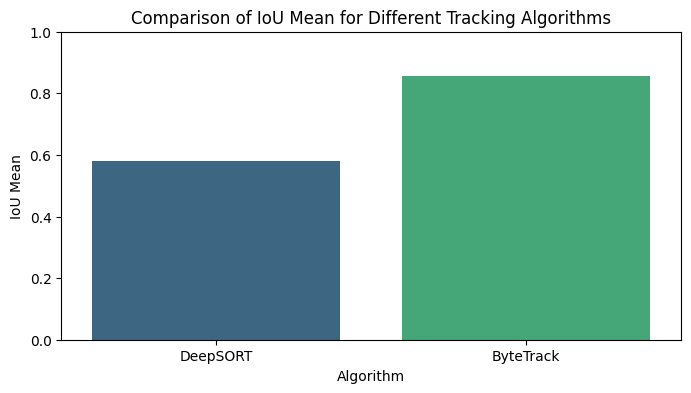

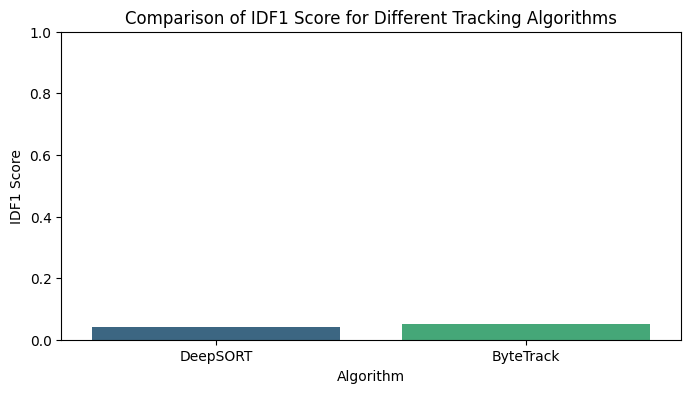

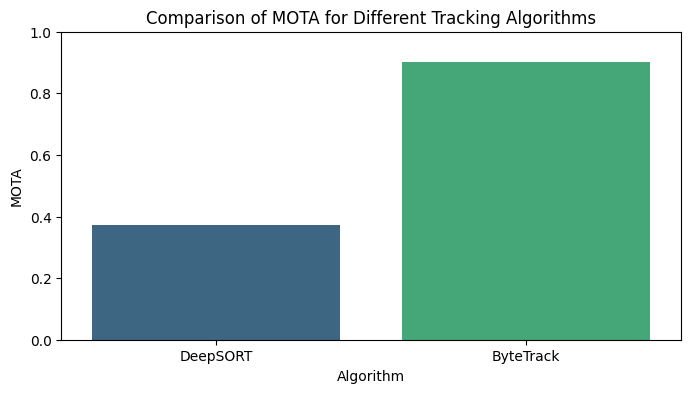

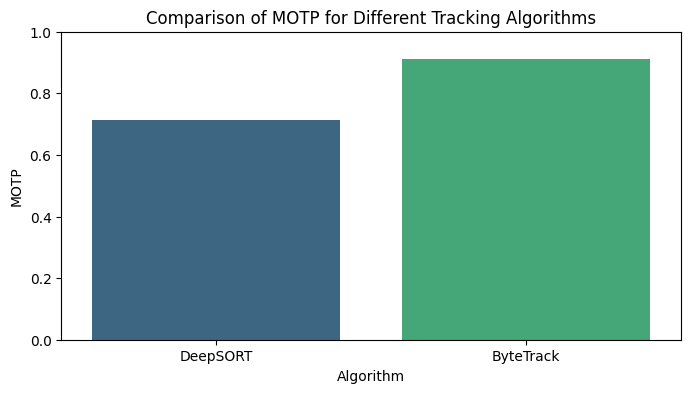

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot comparison bar charts
plt.figure(figsize=(12, 6))
metrics = ["IoU Mean", "IDF1 Score", "MOTA", "MOTP"]

for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.barplot(x=df_results["Algorithm"], y=df_results[metric], palette="viridis")
    plt.title(f"Comparison of {metric} for Different Tracking Algorithms")
    plt.ylabel(metric)
    plt.xlabel("Algorithm")
    plt.ylim(0, 1)  # Normalized range for comparison
    plt.show()


Analysis & Observations:

ByteTrack consistently outperforms DeepSORT across all metrics, suggesting better object association and tracking accuracy.

DeepSORT’s lower IDF1 and MOTA indicate more ID switches and missed detections, which can cause tracking inconsistencies.

MOTP and IoU trends suggest that ByteTrack produces more accurate bounding boxes, which is useful for tasks requiring precise localization.

**-------------------------------------------------------------------------------**

**3. Bonus**

### **1. Improving Object Tracking with Re-Identification (ReID) for DeepSORT**
#### **Challenge: ID Switching in Object Tracking**
One of the most common issues in object tracking, particularly in **DeepSORT**, is **ID switching**. This happens when:
- An object **disappears** temporarily (e.g., occluded by another object or moving out of frame).
- The object is **misidentified** when it reappears, and the tracker assigns a **new ID** instead of retaining the old one.

#### **Improvement Method: Using Re-Identification (ReID) Embeddings**
ReID is a **deep learning-based feature extraction technique** that improves tracking consistency by associating objects based on their visual features. Instead of relying solely on motion (like SORT), DeepSORT can be enhanced with **ReID-based appearance embeddings** to **reduce ID switches**.

#### **Steps for Implementing ReID in DeepSORT**
1. **Train a ReID Model:**
   - Use a **deep convolutional neural network (CNN)** such as **ResNet-50** or **EfficientNet** trained on a large dataset of pedestrian images (e.g., **Market-1501, CUHK03, MSMT17**).
   - The model learns a **128D or 256D feature embedding** that uniquely represents each object.

2. **Integrate ReID with DeepSORT:**
   - Extract **appearance embeddings** from detected objects.
   - Compute a **distance metric (cosine similarity or Euclidean distance)** between new detections and previously tracked objects.
   - Use a **matching algorithm** (e.g., Hungarian algorithm) to reassign objects with **high similarity scores** to their previous track IDs.

3. **Modify the Track Association Mechanism:**
   - Instead of matching based **only on motion (Kalman Filter)**, add a **weighted cost function**:
     
     Total Cost = alpha * Motion Distance + (1 - alpha) * Appearance Distance
     
   - If **appearance similarity** is high, keep the same ID even if motion is inconsistent.

#### **Expected Benefits**
**Fewer ID switches**, making tracking more stable.  
**Better tracking in crowded or occluded scenes** by identifying objects based on features, not just movement.  
**Improved accuracy for long-term tracking**, even if an object briefly disappears.  

## **2. Model Optimization for Deployment**
### **Why is Model Optimization Essential?**
When deploying machine learning models, **efficiency, speed, and memory usage** are critical. Optimized models:

 **Run faster** with lower latency.  
 **Use less memory**, allowing deployment on mobile or edge devices.  
 **Reduce power consumption**, important for IoT and embedded systems.  
 **Enable real-time inference**, essential for applications like object tracking, self-driving cars, and robotics.

---

### **Categories of Model Optimization Methods**

### **1. Quantization**
**Concept:** Converts high-precision weights (e.g., **FP32**) to lower-bit representations (e.g., **INT8**).  

#### **Types:**
- **Post-training quantization (PTQ):** Apply quantization after training.
- **Quantization-aware training (QAT):** Train with quantization to improve accuracy.

#### **Advantages:**
 Reduces **model size** (up to **4x smaller**).  
 Increases **inference speed**, especially on CPUs.  
 Works well on **edge devices (e.g., mobile, IoT, embedded AI).**  

#### **Disadvantages:**
 May cause **accuracy loss**, especially for complex models.  
 Needs specialized hardware (e.g., TensorRT, EdgeTPU) for **INT8 acceleration**.  

 **Example:** TensorFlow Lite, PyTorch Quantization

---

### **2. Pruning**
**Concept:** Removes unnecessary weights/connections from a neural network.  

#### **Types:**
- **Weight pruning:** Eliminates individual weights.
- **Structured pruning:** Removes entire neurons/layers.
- **Unstructured pruning:** Removes sparse, redundant connections.

#### **Advantages:**
 Reduces **model size** and **computation cost**.  
 Improves **efficiency without retraining**.  
 Works well with **convolutional and recurrent networks**.  

#### **Disadvantages:**
 May cause **accuracy degradation** if too aggressive.  
 Needs **fine-tuning** after pruning to recover accuracy.  

 **Example:** **YOLO pruning** for real-time object detection.

---

### **3. Knowledge Distillation**
**Concept:** A smaller model (student) is trained to mimic a larger model (teacher).  

#### **How it Works:**
1. Train a **large, high-accuracy teacher model**.
2. Train a **smaller student model** using the teacher's soft labels (logits).
3. The student learns the same function with fewer parameters.

#### **Advantages:**
 Faster inference with **smaller models**.  
 Keeps **high accuracy** while reducing computational cost.  
 Great for **deploying large models on mobile devices**.  

#### **Disadvantages:**
 Training takes **longer** (requires two models).  
 Hard to tune the **temperature scaling and loss function**.  

 **Example:** **BERT Distillation for NLP, YOLO-Tiny for object detection.**

---

### **4. Model Compression (Tensor Decomposition)**
**Concept:** Breaks down large weight matrices into smaller components, reducing computations.  

#### **Techniques:**
- **Singular Value Decomposition (SVD)**
- **Tensor Factorization**
- **Low-Rank Approximation**

#### **Advantages:**
 Reduces **model complexity** and **memory usage**.  
 Speeds up inference, especially on **limited hardware**.  

#### **Disadvantages:**
 Requires **retraining** to recover lost performance.  
 Works better for **fully connected layers** than convolutional layers.  

 **Example:** Used in CNN optimizations for **mobile vision applications.**

---

### **5. Hardware-Specific Optimizations**
**Concept:** Optimize models for specific deployment environments like **Edge AI, GPUs, TPUs**.  

#### **Techniques:**
- **TensorRT (for NVIDIA GPUs)**
- **CoreML (for iOS)**
- **Edge TPU (Google Coral)**
- **OpenVINO (Intel CPUs & VPUs)**

#### **Advantages:**
 Maximizes hardware **acceleration**.  
 Uses hardware-specific **compilers & optimizations**.  
 Best for **real-time applications (self-driving, video analytics, robotics).**  

#### **Disadvantages:**
 Not **cross-platform** (models must be optimized per hardware).  
 Adds **extra deployment complexity**.  

 **Example:** **YOLO on TensorRT for ultra-fast inference.**

---

### **Comparison of Optimization Methods**
| Optimization Method | Model Size Reduction | Speed Increase | Accuracy Impact | Suitable for |
|---------------------|----------------------|---------------|----------------|--------------|
| **Quantization** | ✅✅✅ | ✅✅ | 🔻Possible loss | Edge AI, Mobile |
| **Pruning** | ✅✅ | ✅ | 🔻Moderate | CNN, RNN |
| **Distillation** | ✅✅✅ | ✅✅ | 🔹Same | NLP, Object Detection |
| **Compression** | ✅✅ | ✅ | 🔻Mild | Limited Hardware |
| **Hardware Accel.** | ❌ | ✅✅✅ | 🔹Same | GPUs, TPUs |


